In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
import ast
import csv
import itertools
import random
from itertools import product
import numpy as np
import pandas as pd

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.ensemble.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.early_stopping import EarlyStopping
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import *
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [5]:
X_train, y_train = load_data(MONK_NUM=2)
X_test, y_test = load_data(MONK_NUM=2, train=False)

one hot encoded data:  (169, 17)
one hot encoded data:  (432, 17)


In [6]:
X_train, X_val = train_test_split(X_train)
y_train, y_val = train_test_split(y_train)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [7]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

Training set size: 135
Validation set size: 34


In [8]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (135, 17)
the shape:  (34, 17)
the shape:  (135, 1)
the shape:  (34, 1)


In [ ]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6]],
    'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
    'batch_norm': [[True], [False]],
    'learning_rate': np.logspace(-3, -1, num=20).tolist(),
    'l1': np.logspace(-5, -1, num=10).tolist(),
    'l2': np.logspace(-5, -1, num=10).tolist(),
    'dropout_rate': np.logspace(-5, -1, num=10).tolist(),
    'batch_size': [8, 16, 32],
    'n_epochs': [50,100],
    'weight_decay': [0, 5e-2, 1e-2, 1e-3, 1e-5],
    'patience': [10, 30, 50]
}

TODO:

Create a seperate best_results csv file for each MONK 

In [12]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,
                                                   param_distributions=param_distributions,
                                                   n_iters=100)  # adjust n_iters as needed

print(best_hyperparams)

[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [10] [False]


NameError: name 'train_and_evaluate' is not defined

In [ ]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, weight_decay, patience, validation_accuracy = best_hyperparams.values()
print(best_hyperparams)

{'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'n_epochs': 50, 'hidden_size': [6], 'hidden_activation': ['Activation_Tanh'], 'batch_norm': [False], 'weight_decay': 0.01, 'patience': 30, 'val_accuracy': 1.0}


GRID SEARCH

In [92]:
activation_map = {
    'Activation_ReLU': Activation_ReLU,
    'Activation_Tanh': Activation_Tanh,
    'Activation_ELU': Activation_ELU,
    'Activation_Leaky_ReLU': Activation_Leaky_ReLU,
    'Activation_Sigmoid': Activation_Sigmoid
}

hidden_activation = [activation_map[act] for act in hidden_activation]  

In [93]:

model = NN(
    l1=l1,
    l2=l2,
    input_size=17,
    hidden_sizes=hidden_size,
    output_size=1,
    hidden_activations=hidden_activation,
    dropout_rates=[dropout_rate],
    use_batch_norm=use_batch_norm
)
# model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU,
#                            output_activation = Activation_Sigmoid)
batch_size = batch_size
learning_rate = learning_rate
n_epochs = n_epochs

[6] [<class 'src.activation_functions.Activation_Tanh'>] [0.1] [False]


Data shapes:
X_train: (135, 17), y_train: (135, 1)
Hyperparams: {'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.001, 'dropout_rate': 0.1, 'batch_size': 16, 'n_epochs': 50, 'hidden_size': [6], 'hidden_activation': ['Activation_Tanh'], 'batch_norm': [False], 'weight_decay': 0.01, 'patience': 30, 'val_accuracy': 1.0}
Epoch 0: Train Loss: 0.3512, Acc: 56.85% | Val Loss: 0.3517, Acc: 55.88%
Epoch 10: Train Loss: 0.0845, Acc: 92.16% | Val Loss: 0.0770, Acc: 100.00%
Epoch 20: Train Loss: 0.0412, Acc: 96.53% | Val Loss: 0.0271, Acc: 100.00%
Epoch 30: Train Loss: 0.0473, Acc: 94.25% | Val Loss: 0.0227, Acc: 100.00%
Epoch 40: Train Loss: 0.0616, Acc: 91.47% | Val Loss: 0.0149, Acc: 100.00%
Final Validation Accuracy: 1.0000
Test Accuracy: 1.0000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0 0 0 0 0 0 0 0 0 0]


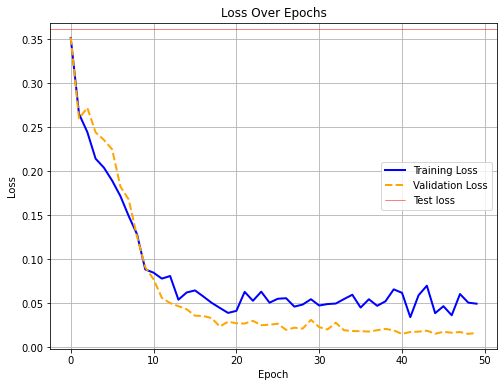

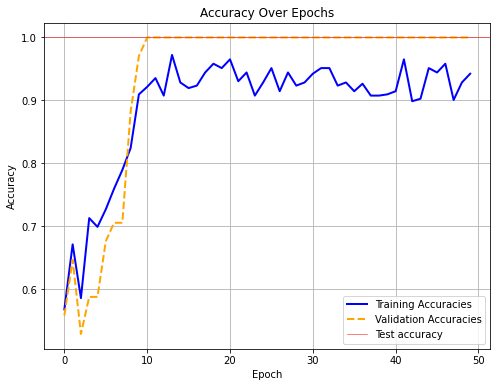

In [94]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=weight_decay)

# Initialize early stopping
early_stopping = EarlyStopping(patience=30, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Hyperparams: {best_hyperparams}")
# print(f"Sample prediction: {model.forward(X_train[:1])}")
# print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"
        
        i = 0
        for layer in reversed(model.layers):
            i=-1
            layer.backward(dvalues)
            dvalues = np.array(layer.dinputs)

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")

    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        # Restore best weights
        print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
        early_stopping.restore_weights(model)
        # Cascade correlation
        if isinstance(model, CascadeCorrelation):
            if model.is_limit_reached():
                break
            
            model.add_neuron()
            early_stopping.wait = 0
            early_stopping.patience -= int(early_stopping.patience / 10)
            early_stopping.stop_training = False
            print(f"Added new neuron at epoch {epoch} wiht val_loss {val_losses[-1]:.4f}")
            continue
        break

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


# Test set evaluation
model.forward(X_test, training=False)
test_loss = loss_function.forward(model.output.squeeze(), y_test)

predictions = np.round(model.output.squeeze())
# y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_test.squeeze())
print(f"Test Accuracy: {test_accuracy:.4f}")
print(predictions[:10].squeeze(), y_test[:10].squeeze())
# Plot training progress
plot_losses(train_losses, val_losses, test_loss,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

plot_accuracies(train_accuracies, val_accuracies, test_accuracy,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

In [50]:
print(train_losses, val_losses)

[0.40356761691883963, 0.4074505507314593, 0.38688989226683745, 0.38873341162437297, 0.40287387476636854, 0.394926614964496, 0.39420222361911955, 0.4090541249441436, 0.3954232743836196, 0.3871263055765686, 0.3911154611006437, 0.4006124760938085, 0.3839421918413699, 0.39106422205462776, 0.3963231848923907, 0.36513323374947826, 0.3943874286642242, 0.39415687854837, 0.36289991219665463, 0.3654686283871002, 0.3604329133162796, 0.31864912954186864, 0.3117621572717445, 0.29856034501013895, 0.2966446358932457, 0.2849224949680508, 0.29645895604825445, 0.28970564898778217, 0.2760915311648665, 0.27313495080266537, 0.2804907276759642, 0.26650504396094615, 0.28155310608838413, 0.26067101863623793, 0.2777449170322392, 0.2578465295738168, 0.25759022671215065, 0.2616280634624337, 0.25873639742959564, 0.2581004482640727, 0.2512723937394454, 0.2486801888444448, 0.25005295617385237, 0.2568275047711346, 0.24288308609700682, 0.2527098971804654, 0.24720765607161727, 0.24993462949010123, 0.25907956916857694,

In [51]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5347


In [32]:
# class EnsembleNN:
#     def __init__(self, n_models=5):
#         self.models = []
#         self.n_models = n_models
#         self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        
            

#     def create_and_train_models(self, hyperparams):
#         # Create and train multiple models with the same hyperparameters
#         for i in range(self.n_models):
#             model = NN(
#                 l1=l1,
#                 l2=l2,
#                 input_size=17,
#                 hidden_sizes=hidden_size,
#                 output_size=1,
#                 hidden_activations=hidden_activation,
#                 dropout_rates=[dropout_rate],
#                 use_batch_norm=use_batch_norm
#             )
#             print(f"Training model {i+1}/{self.n_models}")
#             # Train model using existing train_and_evaluate function
#             model, val_accuracy = train_and_evaluate(
#                 learning_rate=hyperparams['learning_rate'],
#                 # l1=hyperparams['l1'],
#                 # l2=hyperparams['l2'],
#                 # dropout_rate=hyperparams['dropout_rate'],
#                 batch_size=hyperparams['batch_size'],
#                 n_epochs=hyperparams['n_epochs'],
#                 weight_decay=hyperparams['weight_decay'],
#                 # model=hyperparams['model']
#                 # activation=hyperparams['activation']
#                 X_train=X_train,
#                 y_train=y_train,
#                 X_val=X_val,
#                 y_val=y_val,
#                 model=model,
#             )
#             self.models.append(model)
#             print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

#     def predict(self, X):
#         """Make predictions using majority voting"""
#         predictions = []
#         for model in self.models:
#             model.forward(X, training=False)
#             self.loss_activation.forward(
#                 model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
#             pred = np.argmax(self.loss_activation.output, axis=1)
#             predictions.append(pred)

#         # Majority voting
#         predictions = np.array(predictions)
#         final_predictions = np.apply_along_axis(
#             lambda x: np.bincount(x).argmax(),
#             axis=0,
#             arr=predictions
#         )
#         return final_predictions

In [33]:
# ensemble = EnsembleNN(n_models=5)

# ensemble.create_and_train_models(best_hyperparams)

# test_predictions = ensemble.predict(X_test)
# test_accuracy = np.mean(test_predictions == y_test)

# print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")